In [3]:
from datetime import datetime
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
import PIL
import numpy as np

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [4]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print('n_samples: {ns}'.format(ns=n_samples))
print('n_features: {nf}'.format(nf=n_features))
print('n_classes: {}'.format(n_classes))

2017-03-17 07:31:16,286 Loading LFW people faces from /Users/Mike/scikit_learn_data/lfw_home


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [5]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=np.random.RandomState())

In [6]:
n_components = 150

print("Extracting the top {nc} eigenfaces from {nf} faces".format(nc=n_components, nf=X_train.shape[0]))
start = datetime.now()
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
print("done in {dur:.3f}s".format(dur=(datetime.now() - start).total_seconds()))

eigenfaces = pca.components_.reshape((n_components, h, w))

print('Projecting the input data on the eigenfaces orthonormal basis')
start = datetime.now()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in {dur:.3f}s".format(dur=(datetime.now() - start).total_seconds()))

Extracting the top 150 eigenfaces from 966 faces
done in 0.443s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.037s


In [7]:
print('Fitting the classifier to the training set')
start = datetime.now()
param_grid = {'loss': ['modified_huber', 'hinge', 'squared_hinge', 'perceptron']}
clf = GridSearchCV(SGDClassifier(shuffle=True), param_grid)
clf = clf.fit(X_train_pca, y_train)
print('done in {dur:.3f}s'.format(dur=(datetime.now() - start).total_seconds()))
print('Best estimator found by grid search:')
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 0.170s
Best estimator found by grid search:
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


In [8]:
print("Predicting people's names on the test set")
start = datetime.now()
y_pred = clf.predict(X_test_pca)
print("done in {dur:.3f}s".format(dur=(datetime.now() - start).total_seconds()))

print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.002s

Accuracy: 0.78
                   precision    recall  f1-score   support

     Ariel Sharon       0.71      0.24      0.36        21
     Colin Powell       0.73      0.80      0.76        59
  Donald Rumsfeld       0.72      0.91      0.81        32
    George W Bush       0.85      0.86      0.85       140
Gerhard Schroeder       0.71      0.68      0.70        22
      Hugo Chavez       0.69      0.60      0.64        15
       Tony Blair       0.71      0.76      0.74        33

      avg / total       0.77      0.78      0.77       322

[[  5   8   2   3   1   1   1]
 [  1  47   2   6   0   0   3]
 [  0   0  29   3   0   0   0]
 [  1   6   5 120   1   3   4]
 [  0   1   0   5  15   0   1]
 [  0   1   0   2   2   9   1]
 [  0   1   2   3   2   0  25]]


In [9]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    plt.style.use('seaborn-dark')
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


def title(y_pred, y_test, target_names, i):
    """Helper function to extract the prediction titles"""
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: {p}\ntrue:      {t}'.format(p=pred_name, t=true_name)

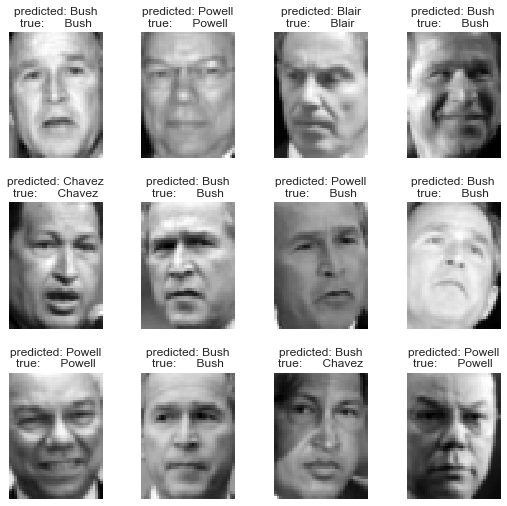

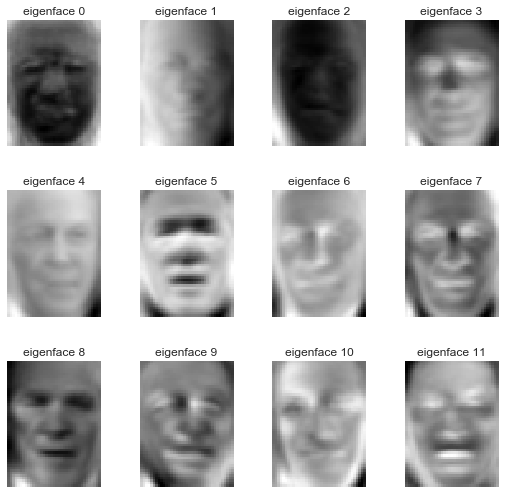

In [10]:
prediction_titles = [title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface {}".format(i) for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()